#  ORIGINAL DOMAIN PROJECTION FROM SEVERAL PRINCIPAL COMPONENTS TRANSFORMATION
## Colab set-up


In [ ]:
# Mount Google Drive
from google.colab import drive 

ROOT = "/content/drive"   
print(ROOT)                 

drive.mount(ROOT)           

import os
folder_path = --- # FILL
os.chdir(folder_path)

## Imports


In [ ]:
# Import of the custom modules
import imp 
models_pytorch = imp.new_module('models_pytorch')
exec(open("./models_pytorch.py").read(), models_pytorch.__dict__)

In [ ]:
import copy
import numpy as np
import torch
import matplotlib.pyplot as plt
import data_transformer as dt

from models_pytorch import ExtendedMultiLR, ExtendedMLP, ExtendedLenet5
from transformers import IdTransformer, NoisyPcaTransformer
from os.path import join  
from torch import nn
from torch import optim
from torchvision import datasets, transforms
from torch.utils.data import Dataset, DataLoader
from PIL import Image

In [ ]:
def eval_model_performance(model, trainloader, validloader, testloader):

    train_performance = model.eval_performance(trainloader)
    validation_performance = model.eval_performance(validloader)
    test_performance = model.eval_performance(testloader)

    print("Train Accuracy %.3f" % (round(train_performance.item(), 3)))
    print("Validation Accuracy %.3f" %(round(validation_performance.item(), 3)))
    print("Test Accuracy %.3f" %(round(test_performance.item(), 3)))

    plt.plot(model.loss_during_training, '-b', 
            label='Training Cross Entropy Loss')
    plt.plot(model.valid_loss_during_training, '-r', 
            label='Validation Cross Entropy Loss')
    plt.xlabel('Iterations')
    plt.ylabel('Loss')
    plt.legend()

## Original MNIST evaluation

In [ ]:
# Define a transform to normalize the data
transform = transforms.Compose([transforms.ToTensor(),
                              transforms.Normalize((0.5,), (0.5,)),
                              ])

# Download and load the training  data
trainset = datasets.MNIST('~/.pytorch/MNIST_data/', download=True, train=True, 
                          transform=transform)
trainloader = torch.utils.data.DataLoader(trainset, batch_size=64, shuffle=False)

# Download and load the test data
testset = datasets.MNIST('~/.pytorch/MNIST_data/', download=True, train=False, 
                         transform=transform)
testloader = torch.utils.data.DataLoader(testset, batch_size=64, shuffle=False)

# Splitting training dataset into train and validation
last_train_index = int(len(trainloader.dataset.data) * 0.8)

validloader = copy.deepcopy(trainloader)  # Creates a copy of the object 

trainloader.dataset.data = trainloader.dataset.data[:last_train_index,:,:]
trainloader.dataset.targets = trainloader.dataset.targets[:last_train_index]

validloader.dataset.data = validloader.dataset.data[last_train_index:,:,:]
validloader.dataset.targets = validloader.dataset.targets[last_train_index:]

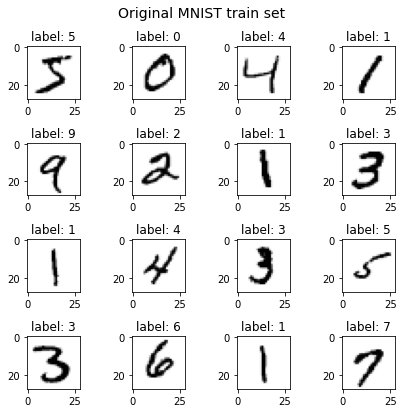

In [ ]:
# Create iterable of train loader and load a chunk
dataiter = iter(trainloader)
images, labels = dataiter.next()

# Plots several example in a grid nrows*ncols
nrows = 4
ncols = 4
num_samples_drawn = int(nrows * ncols)

fig, ax = plt.subplots(nrows, ncols, figsize=(6, 6))

i = 0
for row in range(nrows):
    for col in range(ncols):
        img = images[i].numpy().reshape([28,28])  
        ax[row][col].imshow(img, cmap="Greys")
        fig.show()
        ax[row][col].set_title("label: {}".format(labels[i]))
        i += 1
fig.tight_layout(rect=[0, 0.03, 1, 0.95]) # fix for suptitle 
plt.suptitle("Original MNIST train set", fontsize=14)
plt.show()

### Multi LR

In [ ]:
clean_multi_lr = ExtendedMultiLR(dimx=784, nlabels=10, epochs=10, lr=1e-3)
print(clean_multi_lr)
clean_multi_lr.trainloop(trainloader,validloader)

ExtendedMultiLR(
  (output): Linear(in_features=784, out_features=10, bias=True)
  (logsoftmax): LogSoftmax()
  (criterion): NLLLoss()
)
Epoch 0. Training loss: 0.518179, Validation loss: 0.337584, Time per epoch: 12.109092 seconds
Epoch 1. Training loss: 0.349138, Validation loss: 0.309054, Time per epoch: 12.045395 seconds
Epoch 2. Training loss: 0.328860, Validation loss: 0.299928, Time per epoch: 12.053753 seconds
Epoch 3. Training loss: 0.318719, Validation loss: 0.295595, Time per epoch: 11.935572 seconds
Epoch 4. Training loss: 0.312056, Validation loss: 0.293116, Time per epoch: 12.038513 seconds
Epoch 5. Training loss: 0.307086, Validation loss: 0.291535, Time per epoch: 12.045900 seconds
Epoch 6. Training loss: 0.303123, Validation loss: 0.290463, Time per epoch: 12.059253 seconds
Epoch 7. Training loss: 0.299834, Validation loss: 0.289716, Time per epoch: 12.008730 seconds
Epoch 8. Training loss: 0.297034, Validation loss: 0.289196, Time per epoch: 12.045449 seconds
Epoch 9.

### MLP

In [ ]:
clean_mlp = ExtendedMLP(dimx=784, hidden1=256, hidden2=128, hidden3=64,
                        nlabels=10, epochs=30, lr=1e-3)
print(clean_mlp)
clean_mlp.trainloop(trainloader, validloader)

ExtendedMLP(
  (output1): Linear(in_features=784, out_features=256, bias=True)
  (output2): Linear(in_features=256, out_features=128, bias=True)
  (output3): Linear(in_features=128, out_features=64, bias=True)
  (output4): Linear(in_features=64, out_features=10, bias=True)
  (relu): ReLU()
  (logsoftmax): LogSoftmax()
  (dropout): Dropout(p=0.2, inplace=False)
  (criterion): NLLLoss()
)
Epoch 0. Training loss: 0.532241, Validation loss: 0.250341, Time per epoch: 13.702415 seconds
Epoch 1. Training loss: 0.265213, Validation loss: 0.168985, Time per epoch: 13.558324 seconds
Epoch 2. Training loss: 0.211376, Validation loss: 0.160716, Time per epoch: 13.661292 seconds
Epoch 3. Training loss: 0.184295, Validation loss: 0.142112, Time per epoch: 13.542036 seconds
Epoch 4. Training loss: 0.164619, Validation loss: 0.123364, Time per epoch: 13.604531 seconds
Epoch 5. Training loss: 0.150672, Validation loss: 0.133101, Time per epoch: 13.748914 seconds
Epoch 6. Training loss: 0.142601, Valida

### Lenet5

In [ ]:
clean_lenet5 = ExtendedLenet5(dimx=28, nlabels=10, epochs=10, use_batch_norm=True)
print(clean_lenet5)
clean_lenet5.trainloop(trainloader,validloader)

ExtendedLenet5(
  (conv1): Conv2d(1, 6, kernel_size=(5, 5), stride=(1, 1))
  (conv2): Conv2d(6, 16, kernel_size=(5, 5), stride=(1, 1))
  (pool): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (output1): Linear(in_features=256, out_features=120, bias=True)
  (output2): Linear(in_features=120, out_features=84, bias=True)
  (output3): Linear(in_features=84, out_features=10, bias=True)
  (relu): ReLU()
  (logsoftmax): LogSoftmax()
  (dropout): Dropout(p=0.4, inplace=False)
  (batch_norm1): BatchNorm2d(6, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (batch_norm2): BatchNorm2d(16, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (criterion): NLLLoss()
)
Epoch 0. Training loss: 0.379155, Validation loss: 0.084761, Time per epoch: 15.138931 seconds
Epoch 1. Training loss: 0.119528, Validation loss: 0.063707, Time per epoch: 15.282914 seconds
Epoch 2. Training loss: 0.091975, Validation loss: 0.059602, Time per epoch: 15.153542

In [ ]:
class CustomDataset(Dataset):
    """Pytorch dataset extension.

    This module allows to transform a set of data and targets numpy variables 
    into a pytorch dataset.
    """
    def __init__(self, data, targets, transform=None):
        self.data = data
        self.targets = torch.LongTensor(targets)
        self.transform = transform

    def __getitem__(self, index):
        x = self.data[index]
        y = self.targets[index]

        if self.transform:
            x = Image.fromarray(self.data[index].astype(np.uint8))
            x = self.transform(x)

        return x, y

    def __len__(self):
        return len(self.data)

## Transformed MNIST evaluation
Half of the instances have been transformed. The instances have been projected to a lower feature space given by 5 PCA components. Then, instances in that reduced feature space are projected back to the original space.




In [ ]:
TRANSFORMED_DATA_PATH = join(GIT_REPOSITORY_PATH, 
                             "exp1/output_data_transformer/")

# Loading the data
x_train = np.load(join(TRANSFORMED_DATA_PATH, "mnist_x_train_tr_proj_pca.npy"))
y_train = np.load(join(TRANSFORMED_DATA_PATH, "mnist_y_train_tr_proj_pca.npy"))

x_test = np.load(join(TRANSFORMED_DATA_PATH, "mnist_x_test_tr_proj_pca.npy"))
y_test = np.load(join(TRANSFORMED_DATA_PATH, "mnist_y_test_tr_proj_pca.npy"))

# Need to be reshaped
x_train = x_train.reshape(60000, 1, 28, 28)
x_test = x_test.reshape(10000, 1, 28, 28)

# Transform into pytorch datasets
trainset = CustomDataset(x_train, y_train, transform=None)
testset = CustomDataset(x_test, y_test, transform=None)

# Transform into pytorch loaders
trainloader = torch.utils.data.DataLoader(trainset, batch_size=64, shuffle=True)
testloader = torch.utils.data.DataLoader(testset, batch_size=64, shuffle=True)

# Splitting training dataset into train and validation
last_train_index = int(len(trainloader.dataset.data) * 0.8)

validloader = copy.deepcopy(trainloader)  # Creates a copy of the object 

trainloader.dataset.data = trainloader.dataset.data[:last_train_index,:,:]
trainloader.dataset.targets = trainloader.dataset.targets[:last_train_index]

validloader.dataset.data = validloader.dataset.data[last_train_index:,:,:]
validloader.dataset.targets = validloader.dataset.targets[last_train_index:]

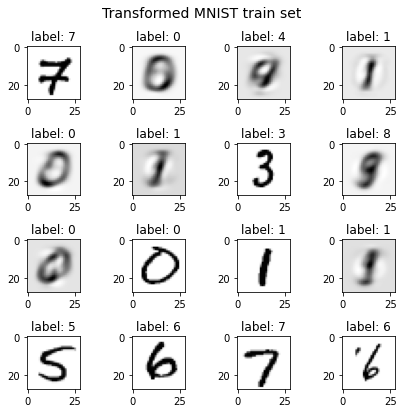

In [ ]:
# Create iterable of train loader and load a chunk
dataiter = iter(trainloader)
images, labels = dataiter.next()

# Plots several example in a grid nrows*ncols
nrows = 4
ncols = 4
num_samples_drawn = int(nrows * ncols)

fig, ax = plt.subplots(nrows, ncols, figsize=(6, 6))

i = 0
for row in range(nrows):
    for col in range(ncols):
        img = images[i].numpy().reshape([28,28])
        ax[row][col].imshow(img, cmap="Greys")
        fig.show()
        ax[row][col].set_title("label: {}".format(labels[i]))
        i += 1
fig.tight_layout(rect=[0, 0.03, 1, 0.95]) # fix for suptitle 
plt.suptitle("Transformed MNIST train set", fontsize=14)
plt.show()

### Testing performance of clean models
#### Multi LR

Train Accuracy 0.762
Validation Accuracy 0.761
Test Accuracy 0.763


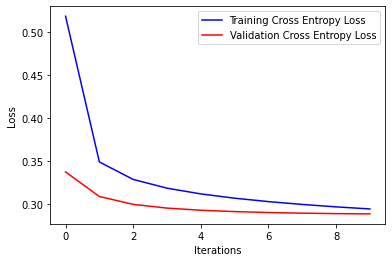

In [ ]:
eval_model_performance(clean_multi_lr, trainloader, validloader, testloader)

#### MLP 

Train Accuracy 0.746
Validation Accuracy 0.744
Test Accuracy 0.739


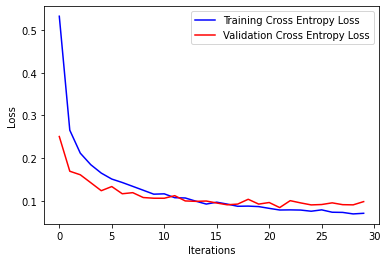

In [ ]:
eval_model_performance(clean_mlp, trainloader, validloader, testloader)

#### Lenet-5

Train Accuracy 0.768
Validation Accuracy 0.764
Test Accuracy 0.768


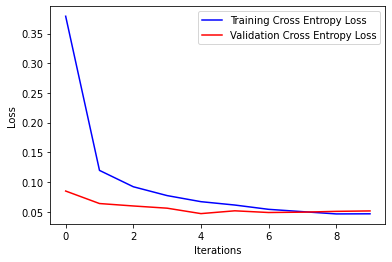

In [ ]:
eval_model_performance(clean_lenet5, trainloader, validloader, testloader)

### Multi LR

In [ ]:
transf_multi_lr = ExtendedMultiLR(dimx=784, nlabels=10, epochs=10, lr=1e-3)
print(transf_multi_lr)

ExtendedMultiLR(
  (output): Linear(in_features=784, out_features=10, bias=True)
  (logsoftmax): LogSoftmax()
  (criterion): NLLLoss()
)


In [ ]:
transf_multi_lr.trainloop(trainloader,validloader)

Epoch 0. Training loss: 0.787782, Validation loss: 0.704264, Time per epoch: 1.693867 seconds
Epoch 1. Training loss: 0.659588, Validation loss: 0.645084, Time per epoch: 1.702870 seconds
Epoch 2. Training loss: 0.644062, Validation loss: 0.674789, Time per epoch: 1.708622 seconds
Epoch 3. Training loss: 0.641708, Validation loss: 0.633810, Time per epoch: 1.705357 seconds
Epoch 4. Training loss: 0.633559, Validation loss: 0.658329, Time per epoch: 1.706700 seconds
Epoch 5. Training loss: 0.632072, Validation loss: 0.628998, Time per epoch: 1.695824 seconds
Epoch 6. Training loss: 0.627606, Validation loss: 0.622028, Time per epoch: 1.693932 seconds
Epoch 7. Training loss: 0.625729, Validation loss: 0.662549, Time per epoch: 1.701905 seconds
Epoch 8. Training loss: 0.623799, Validation loss: 0.655041, Time per epoch: 1.688217 seconds
Epoch 9. Training loss: 0.623949, Validation loss: 0.641842, Time per epoch: 1.684178 seconds


Train Accuracy 0.785
Validation Accuracy 0.780
Test Accuracy 0.787


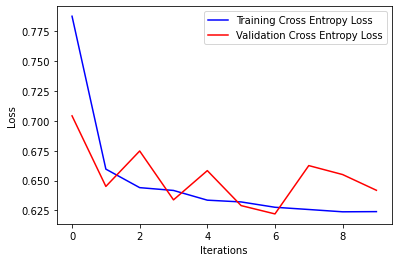

In [ ]:
eval_model_performance(transf_multi_lr, trainloader, validloader, testloader)

### MLP

In [ ]:
transf_mlp = ExtendedMLP(dimx=784, hidden1=256, hidden2=128, hidden3=64,
                  nlabels=10, epochs=30, lr=1e-3)
print(transf_mlp)

ExtendedMLP(
  (output1): Linear(in_features=784, out_features=256, bias=True)
  (output2): Linear(in_features=256, out_features=128, bias=True)
  (output3): Linear(in_features=128, out_features=64, bias=True)
  (output4): Linear(in_features=64, out_features=10, bias=True)
  (relu): ReLU()
  (logsoftmax): LogSoftmax()
  (dropout): Dropout(p=0.2, inplace=False)
  (criterion): NLLLoss()
)


In [ ]:
transf_mlp.trainloop(trainloader, validloader)

Epoch 0. Training loss: 0.826591, Validation loss: 0.555704, Time per epoch: 3.254776 seconds
Epoch 1. Training loss: 0.597113, Validation loss: 0.511491, Time per epoch: 3.259228 seconds
Epoch 2. Training loss: 0.551552, Validation loss: 0.485895, Time per epoch: 3.247823 seconds
Epoch 3. Training loss: 0.531657, Validation loss: 0.469428, Time per epoch: 3.274524 seconds
Epoch 4. Training loss: 0.515893, Validation loss: 0.465982, Time per epoch: 3.235870 seconds
Epoch 5. Training loss: 0.496920, Validation loss: 0.449567, Time per epoch: 3.253926 seconds
Epoch 6. Training loss: 0.492929, Validation loss: 0.463001, Time per epoch: 3.196603 seconds
Epoch 7. Training loss: 0.482268, Validation loss: 0.456161, Time per epoch: 3.222044 seconds
Epoch 8. Training loss: 0.474158, Validation loss: 0.446502, Time per epoch: 3.236994 seconds
Epoch 9. Training loss: 0.470000, Validation loss: 0.442673, Time per epoch: 3.260009 seconds
Epoch 10. Training loss: 0.467685, Validation loss: 0.446865

Train Accuracy 0.870
Validation Accuracy 0.853
Test Accuracy 0.862


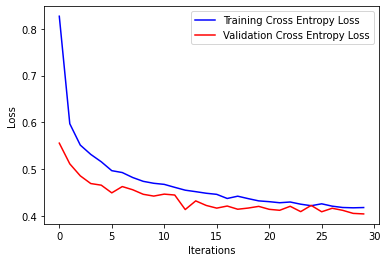

In [ ]:
eval_model_performance(transf_mlp, trainloader, validloader, testloader)

### Lenet5

In [ ]:
transf_lenet5 = ExtendedLenet5(dimx=28, nlabels=10, epochs=10, use_batch_norm=True)
print(transf_lenet5)

ExtendedLenet5(
  (conv1): Conv2d(1, 6, kernel_size=(5, 5), stride=(1, 1))
  (conv2): Conv2d(6, 16, kernel_size=(5, 5), stride=(1, 1))
  (pool): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (output1): Linear(in_features=256, out_features=120, bias=True)
  (output2): Linear(in_features=120, out_features=84, bias=True)
  (output3): Linear(in_features=84, out_features=10, bias=True)
  (relu): ReLU()
  (logsoftmax): LogSoftmax()
  (dropout): Dropout(p=0.4, inplace=False)
  (batch_norm1): BatchNorm2d(6, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (batch_norm2): BatchNorm2d(16, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (criterion): NLLLoss()
)


In [ ]:
transf_lenet5.trainloop(trainloader, validloader)

Epoch 0. Training loss: 0.738790, Validation loss: 0.457658, Time per epoch: 4.790407 seconds
Epoch 1. Training loss: 0.506974, Validation loss: 0.419134, Time per epoch: 4.769158 seconds
Epoch 2. Training loss: 0.473726, Validation loss: 0.400551, Time per epoch: 4.731042 seconds
Epoch 3. Training loss: 0.451789, Validation loss: 0.390557, Time per epoch: 4.813919 seconds
Epoch 4. Training loss: 0.437991, Validation loss: 0.384312, Time per epoch: 4.795506 seconds
Epoch 5. Training loss: 0.429813, Validation loss: 0.378247, Time per epoch: 4.862467 seconds
Epoch 6. Training loss: 0.421943, Validation loss: 0.376107, Time per epoch: 4.830504 seconds
Epoch 7. Training loss: 0.419419, Validation loss: 0.372889, Time per epoch: 4.826333 seconds
Epoch 8. Training loss: 0.413735, Validation loss: 0.388593, Time per epoch: 4.807284 seconds
Epoch 9. Training loss: 0.404008, Validation loss: 0.372792, Time per epoch: 4.836429 seconds


Train Accuracy 0.871
Validation Accuracy 0.861
Test Accuracy 0.868


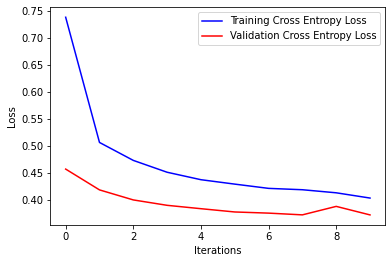

In [ ]:
eval_model_performance(transf_lenet5, trainloader, validloader, testloader)

## Aligned MNIST evaluation
The images which were transformed have been domain aligned back to their original domain with CycleGAN.



In [ ]:
ALIGNED_DATA_PATH = join(GIT_REPOSITORY_PATH, 
                             "exp1/output_gan_image_loader/")

# Loading the data
x_train = np.load(join(ALIGNED_DATA_PATH, "mnist_x_train_aligned_proj_pca.npy"))
y_train = np.load(join(ALIGNED_DATA_PATH, "mnist_y_train_aligned_proj_pca.npy"))

x_test = np.load(join(ALIGNED_DATA_PATH, "mnist_x_test_aligned_proj_pca.npy"))
y_test = np.load(join(ALIGNED_DATA_PATH, "mnist_y_test_aligned_proj_pca.npy"))

# Transform into pytorch datasets
trainset = CustomDataset(x_train, y_train, transform=transform)
testset = CustomDataset(x_test, y_test, transform=transform)

# Transform into pytorch loaders
trainloader = torch.utils.data.DataLoader(trainset, batch_size=64, shuffle=True)
testloader = torch.utils.data.DataLoader(testset, batch_size=64, shuffle=True)

# Splitting training dataset into train and validation
last_train_index = int(len(trainloader.dataset.data) * 0.8)

validloader = copy.deepcopy(trainloader)  # Creates a copy of the object 

trainloader.dataset.data = trainloader.dataset.data[:last_train_index,:,:]
trainloader.dataset.targets = trainloader.dataset.targets[:last_train_index]

validloader.dataset.data = validloader.dataset.data[last_train_index:,:,:]
validloader.dataset.targets = validloader.dataset.targets[last_train_index:]

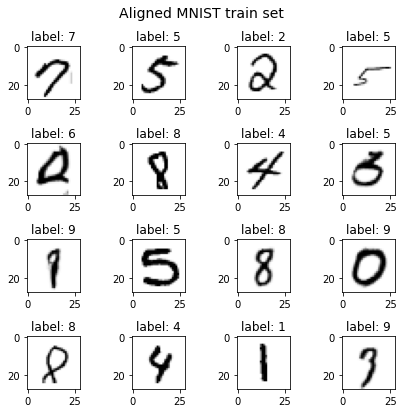

In [ ]:
# Create iterable of train loader and load a chunk
dataiter = iter(trainloader)
images, labels = dataiter.next()

# Plots several example in a grid nrows*ncols
nrows = 4
ncols = 4
num_samples_drawn = int(nrows * ncols)

fig, ax = plt.subplots(nrows, ncols, figsize=(6, 6))

i = 0
for row in range(nrows):
    for col in range(ncols):
        img = images[i].numpy().reshape([28,28])  
        ax[row][col].imshow(img, cmap="Greys")
        fig.show()
        ax[row][col].set_title("label: {}".format(labels[i]))
        i += 1
fig.tight_layout(rect=[0, 0.03, 1, 0.95]) # fix for suptitle 
plt.suptitle("Aligned MNIST train set", fontsize=14)
plt.show()

### Testing performance of clean models
#### Multi LR

Train Accuracy 0.760
Validation Accuracy 0.768
Test Accuracy 0.765


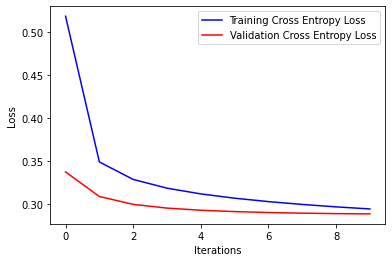

In [ ]:
eval_model_performance(clean_multi_lr, trainloader, validloader, testloader)

#### MLP

Train Accuracy 0.792
Validation Accuracy 0.793
Test Accuracy 0.790


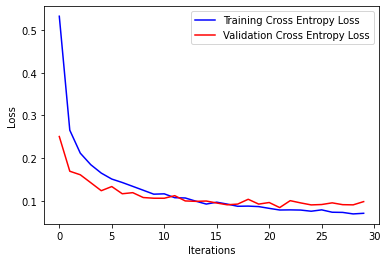

In [ ]:
eval_model_performance(clean_mlp, trainloader, validloader, testloader)

#### Lenet5

Train Accuracy 0.794
Validation Accuracy 0.796
Test Accuracy 0.800


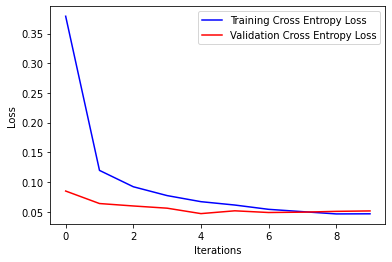

In [ ]:
eval_model_performance(clean_lenet5, trainloader, validloader, testloader)

### Multi LR

In [ ]:
aligned_multi_lr = ExtendedMultiLR(dimx=784, nlabels=10, epochs=10, lr=1e-3)
print(aligned_multi_lr)

ExtendedMultiLR(
  (output): Linear(in_features=784, out_features=10, bias=True)
  (logsoftmax): LogSoftmax()
  (criterion): NLLLoss()
)


In [ ]:
aligned_multi_lr.trainloop(trainloader,validloader)

Epoch 0. Training loss: 0.814626, Validation loss: 0.695193, Time per epoch: 12.064955 seconds
Epoch 1. Training loss: 0.700905, Validation loss: 0.677358, Time per epoch: 12.070812 seconds
Epoch 2. Training loss: 0.680103, Validation loss: 0.660570, Time per epoch: 12.229316 seconds
Epoch 3. Training loss: 0.669668, Validation loss: 0.663833, Time per epoch: 12.152891 seconds
Epoch 4. Training loss: 0.661504, Validation loss: 0.691621, Time per epoch: 12.195813 seconds
Epoch 5. Training loss: 0.653084, Validation loss: 0.663674, Time per epoch: 12.258668 seconds
Epoch 6. Training loss: 0.649642, Validation loss: 0.653592, Time per epoch: 12.015384 seconds
Epoch 7. Training loss: 0.648604, Validation loss: 0.637170, Time per epoch: 12.168842 seconds
Epoch 8. Training loss: 0.640435, Validation loss: 0.667460, Time per epoch: 12.243163 seconds
Epoch 9. Training loss: 0.639265, Validation loss: 0.680354, Time per epoch: 12.194011 seconds


Train Accuracy 0.779
Validation Accuracy 0.771
Test Accuracy 0.775


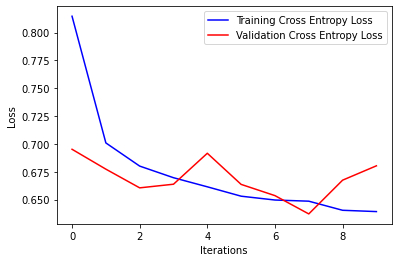

In [ ]:
eval_model_performance(aligned_multi_lr, trainloader, validloader, testloader)

### MLP

In [ ]:
aligned_mlp = ExtendedMLP(dimx=784, hidden1=256, hidden2=128, hidden3=64,
                  nlabels=10, epochs=30, lr=1e-3)
print(aligned_mlp)

ExtendedMLP(
  (output1): Linear(in_features=784, out_features=256, bias=True)
  (output2): Linear(in_features=256, out_features=128, bias=True)
  (output3): Linear(in_features=128, out_features=64, bias=True)
  (output4): Linear(in_features=64, out_features=10, bias=True)
  (relu): ReLU()
  (logsoftmax): LogSoftmax()
  (dropout): Dropout(p=0.2, inplace=False)
  (criterion): NLLLoss()
)


In [ ]:
aligned_mlp.trainloop(trainloader, validloader)

Epoch 0. Training loss: 0.845775, Validation loss: 0.616275, Time per epoch: 13.663205 seconds
Epoch 1. Training loss: 0.628289, Validation loss: 0.529178, Time per epoch: 13.649271 seconds
Epoch 2. Training loss: 0.581422, Validation loss: 0.490663, Time per epoch: 13.727989 seconds
Epoch 3. Training loss: 0.549922, Validation loss: 0.478284, Time per epoch: 13.594339 seconds
Epoch 4. Training loss: 0.529500, Validation loss: 0.481789, Time per epoch: 13.427146 seconds
Epoch 5. Training loss: 0.519185, Validation loss: 0.453299, Time per epoch: 13.589859 seconds
Epoch 6. Training loss: 0.506323, Validation loss: 0.444570, Time per epoch: 13.694945 seconds
Epoch 7. Training loss: 0.493716, Validation loss: 0.444689, Time per epoch: 13.640032 seconds
Epoch 8. Training loss: 0.485026, Validation loss: 0.454855, Time per epoch: 13.741954 seconds
Epoch 9. Training loss: 0.476836, Validation loss: 0.437907, Time per epoch: 13.585651 seconds
Epoch 10. Training loss: 0.470283, Validation loss

Train Accuracy 0.868
Validation Accuracy 0.850
Test Accuracy 0.851


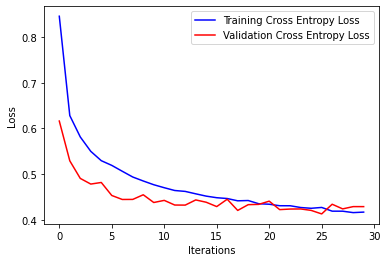

In [ ]:
eval_model_performance(aligned_mlp, trainloader, validloader, testloader)

### Lenet5

In [ ]:
aligned_lenet5 = ExtendedLenet5(dimx=28, nlabels=10, epochs=10, use_batch_norm=True)
print(aligned_lenet5)

ExtendedLenet5(
  (conv1): Conv2d(1, 6, kernel_size=(5, 5), stride=(1, 1))
  (conv2): Conv2d(6, 16, kernel_size=(5, 5), stride=(1, 1))
  (pool): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (output1): Linear(in_features=256, out_features=120, bias=True)
  (output2): Linear(in_features=120, out_features=84, bias=True)
  (output3): Linear(in_features=84, out_features=10, bias=True)
  (relu): ReLU()
  (logsoftmax): LogSoftmax()
  (dropout): Dropout(p=0.4, inplace=False)
  (batch_norm1): BatchNorm2d(6, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (batch_norm2): BatchNorm2d(16, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (criterion): NLLLoss()
)


In [ ]:
aligned_lenet5.trainloop(trainloader, validloader)

Epoch 0. Training loss: 0.790328, Validation loss: 0.498097, Time per epoch: 15.041822 seconds
Epoch 1. Training loss: 0.567348, Validation loss: 0.452597, Time per epoch: 14.983041 seconds
Epoch 2. Training loss: 0.524090, Validation loss: 0.434484, Time per epoch: 15.038769 seconds
Epoch 3. Training loss: 0.500091, Validation loss: 0.419976, Time per epoch: 14.911326 seconds
Epoch 4. Training loss: 0.482766, Validation loss: 0.415737, Time per epoch: 14.972480 seconds
Epoch 5. Training loss: 0.472615, Validation loss: 0.416330, Time per epoch: 14.853662 seconds
Epoch 6. Training loss: 0.465199, Validation loss: 0.409128, Time per epoch: 14.875001 seconds
Epoch 7. Training loss: 0.453719, Validation loss: 0.409777, Time per epoch: 14.974199 seconds
Epoch 8. Training loss: 0.447863, Validation loss: 0.413028, Time per epoch: 15.032504 seconds
Epoch 9. Training loss: 0.438324, Validation loss: 0.407308, Time per epoch: 15.046853 seconds


Train Accuracy 0.864
Validation Accuracy 0.856
Test Accuracy 0.855


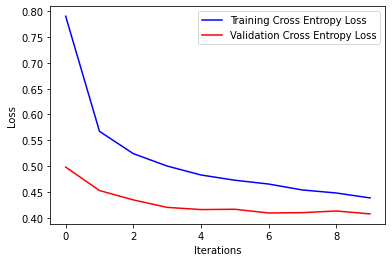

In [ ]:
eval_model_performance(aligned_lenet5, trainloader, validloader, testloader)